In [ ]:
# This notebook contains code to analyze Amazon book reviews and metadata.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import kagglehub
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score, recall_score, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pathlib import Path


In [ ]:
# def load_data(ads_path: Path, feeds_path: Path) -> pd.DataFrame:
#   feeds: pd.DataFrame = pd.read_csv(feeds_path)
#   ads: pd.DataFrame = pd.read_csv(ads_path)
#   return merge_data(ads=ads, feeds=feeds)

In [ ]:

#Downloads book reviews data
data_path = Path(kagglehub.dataset_download("mohamedbakhet/amazon-books-reviews"))

# data_books = load_data(
#     ratings = data_path / "Books_rating.csv",
#     books = data_path / "books_data.csv"
# )


ratings = pd.read_csv(data_path / "Books_rating.csv")




In [ ]:
books = pd.read_csv(data_path / "books_data.csv")
books.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


Book Metadata and Ratings Analysis

Research Question: Does genre (e.g., fiction, biography, academic) correlate with average score?


In [ ]:
# Merge datasets on book title
merged_df = pd.merge(ratings, books, on="Title", how="inner")

# Drop rows where categories or review score is missing
merged_df = merged_df.dropna(subset=["categories", "review/score"])

# If categories is a list (e.g., "['Fiction']"), extract the first genre
def extract_primary_genre(cat):
    try:
        # Safe eval-style string to list conversion
        if cat.startswith("[") and cat.endswith("]"):
            return eval(cat)[0] if eval(cat) else None
        return cat
    except:
        return None

merged_df["primary_genre"] = merged_df["categories"].apply(extract_primary_genre)

# Group by genre and calculate both average score and review count
genre_stats = (
    merged_df.groupby("primary_genre")["review/score"]
    .agg(["mean", "count"])
    .reset_index()
    .rename(columns={"mean": "average_score", "count": "num_reviews"})
)

# Filter for genres with at least 10000 reviews
filtered_genre_stats = genre_stats[genre_stats["num_reviews"] >= 10000]

# Sort by average review score
filtered_genre_stats = filtered_genre_stats.sort_values(by="average_score", ascending=False)

# Display results
print(filtered_genre_stats.head(10))

            primary_genre  average_score  num_reviews
7072     Juvenile Fiction       4.453768       207542
7073  Juvenile Nonfiction       4.418627        29248
8915               Poetry       4.416154        10239
3689              Cooking       4.397525        29895
9724            Self-Help       4.393529        29083
7410   Literary Criticism       4.388198        17285
4497                Drama       4.386133        14394
1001                  Art       4.372044        12813
3889     Crafts & Hobbies       4.338813        13078
9371             Religion       4.338134        98035


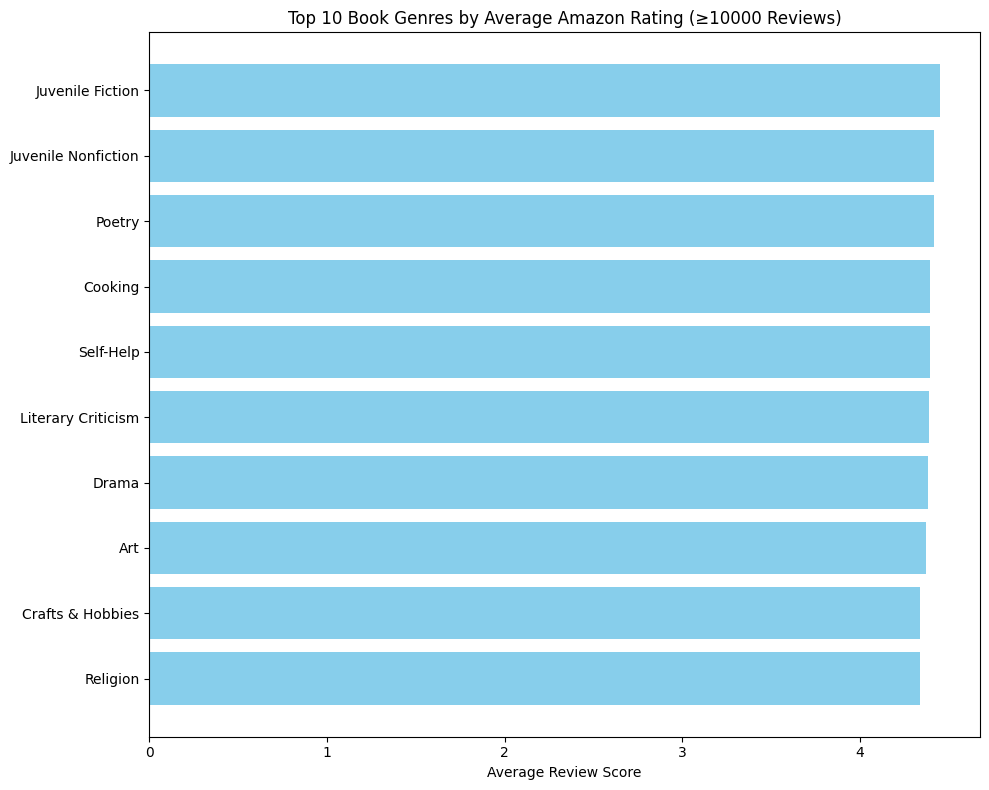

In [ ]:
import matplotlib.pyplot as plt

# Select top 10 genres by average score
top_genres = filtered_genre_stats.head(10)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(top_genres["primary_genre"], top_genres["average_score"], color="skyblue")
plt.xlabel("Average Review Score")
plt.title("Top 10 Book Genres by Average Amazon Rating (≥10000 Reviews)")
plt.gca().invert_yaxis()  # Highest score on top
plt.tight_layout()
plt.show()

It doesn't looks like any single genre tends to score better, but Juvenile fiction and nonfiction are the top categories.

Research Question: Are certain publishers or authors consistently associated with higher or lower ratings?

In [ ]:
# --- Publisher analysis ---
publisher_stats = (
    merged_df.groupby("publisher")["review/score"]
    .agg(["mean", "count"])
    .reset_index()
    .rename(columns={"mean": "average_score", "count": "num_reviews"})
)

# Filter for publishers with at least 10000 reviews
filtered_publishers = publisher_stats[publisher_stats["num_reviews"] >= 10000]
top_publishers = filtered_publishers.sort_values(by="average_score", ascending=False)

print(top_publishers.head(10))


                                   publisher  average_score  num_reviews
8309                           Mariner Books       4.631125        30143
5750                           HarperCollins       4.431726        28664
3229                     Courier Corporation       4.405917        37589
7760   Little, Brown Books for Young Readers       4.396487        12467
6175               Houghton Mifflin Harcourt       4.388126        28246
5760                        HarperCollins UK       4.333923        12434
9992                         Open Road Media       4.291710        16321
11305                           Random House       4.277423        46229
5729                          Harper Collins       4.236526        84921
12407                     Simon and Schuster       4.189017       118069


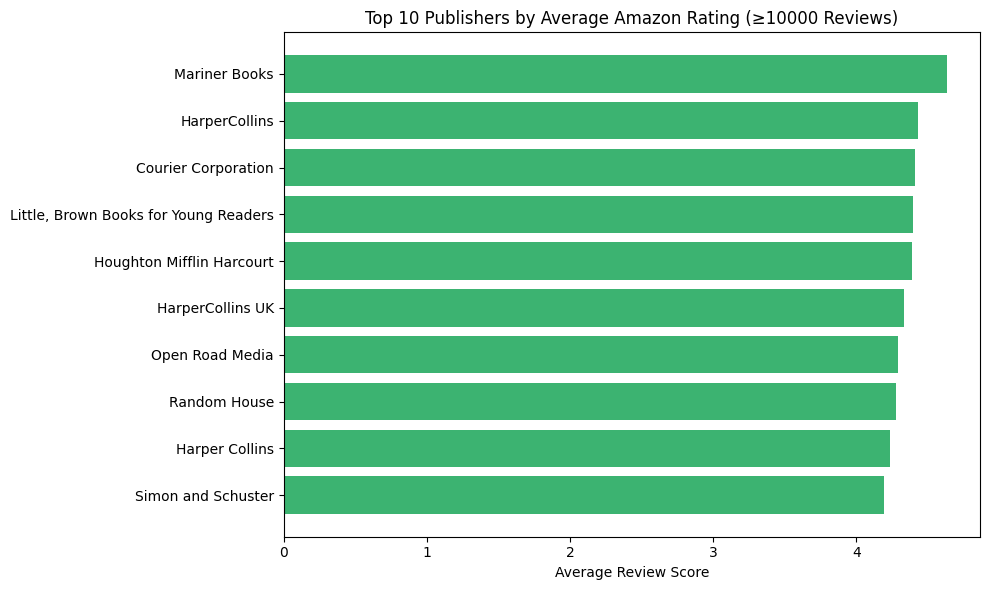

In [ ]:
# Plot top 10 publishers
top_10_publishers = top_publishers.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_publishers["publisher"], top_10_publishers["average_score"], color="mediumseagreen")
plt.xlabel("Average Review Score")
plt.title("Top 10 Publishers by Average Amazon Rating (≥10000 Reviews)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Clearly certain publishers have higher ratings on average than others.

In [ ]:
# Author analysis

import ast

# Convert string list to actual Python list and extract first author
def extract_primary_author(raw):
    if pd.isnull(raw):
        return None
    try:
        parsed = ast.literal_eval(raw)
        return parsed[0].strip() if isinstance(parsed, list) and parsed else raw.strip()
    except:
        return raw.strip()

merged_df["primary_author"] = merged_df["authors"].apply(extract_primary_author)

# Manually map common duplicates to canonical names
author_aliases = {
    "John Ronald Reuel Tolkien": "J. R. R. Tolkien",
    "J R R Tolkien": "J. R. R. Tolkien",
    "C. S. Lewis": "C.S. Lewis",
    "Lewis Carroll": "Charles Lutwidge Dodgson",  # optional depending on consistency
    # Add more aliases if needed
}

merged_df["primary_author"] = merged_df["primary_author"].replace(author_aliases)

author_stats = (
    merged_df.groupby("primary_author")["review/score"]
    .agg(["mean", "count"])
    .reset_index()
    .rename(columns={"mean": "average_score", "count": "num_reviews"})
)

# Filter for authors with at least 10000 reviews
filtered_authors = author_stats[author_stats["num_reviews"] >= 10000]
top_authors = filtered_authors.sort_values(by="average_score", ascending=False)

print(top_authors.head(10))

                 primary_author  average_score  num_reviews
43746          J. R. R. Tolkien       4.632219        49902
39411                Harper Lee       4.548656        12013
12670                C.S. Lewis       4.547120        14357
36019             George Orwell       4.542350        10189
15758          Charlotte Brontë       4.437626        10429
46733               Jane Austen       4.434710        31161
53848            John Steinbeck       4.361043        17034
60874             Kurt Vonnegut       4.327096        12131
14926           Charles Dickens       4.284333        19129
15279  Charles Lutwidge Dodgson       4.185776        11417


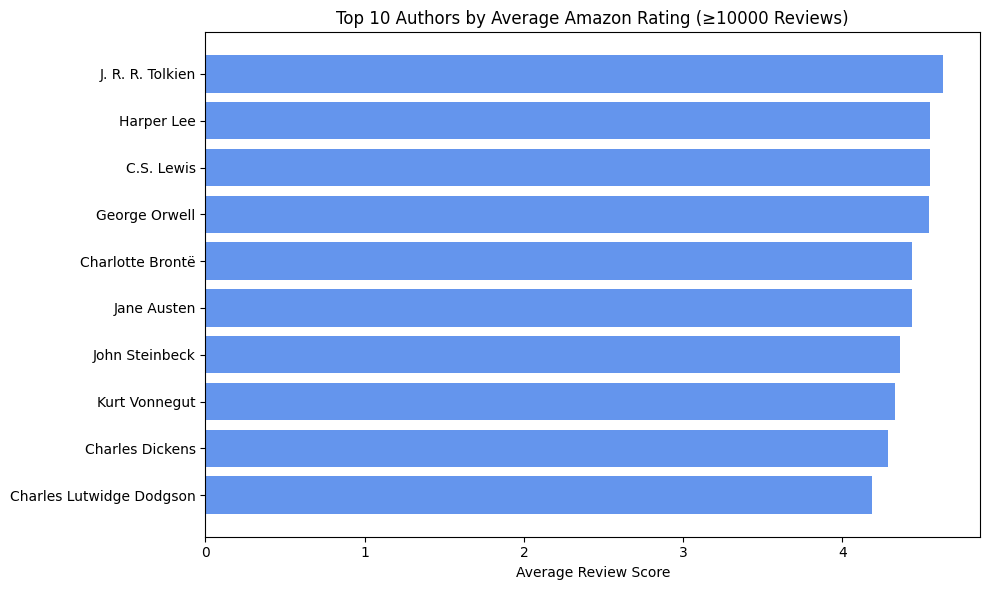

In [ ]:
# Plot top 10 authors
top_10_authors = top_authors.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_authors["primary_author"], top_10_authors["average_score"], color="cornflowerblue")
plt.xlabel("Average Review Score")
plt.title("Top 10 Authors by Average Amazon Rating (≥10000 Reviews)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Also a significant difference between author ratings, with iconic writers being at the top of the list.

How do their sentiments change over time?

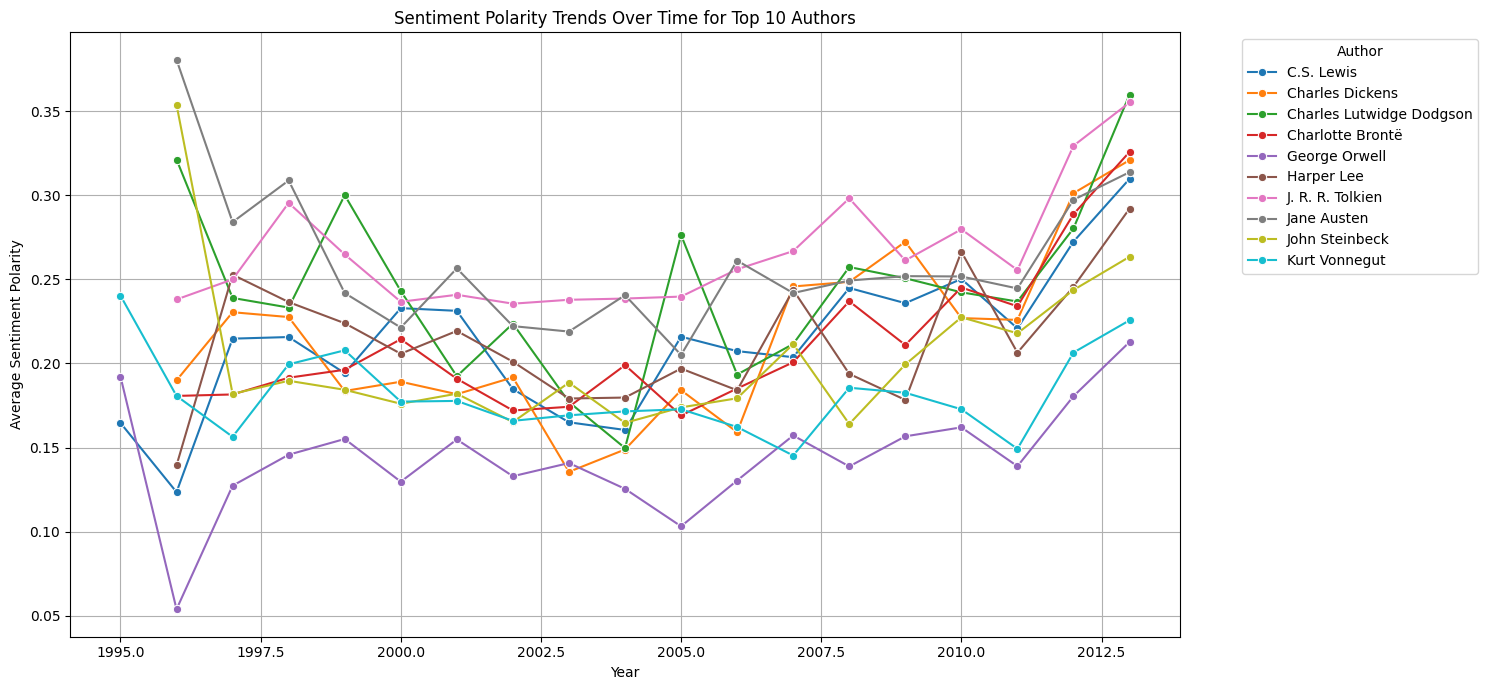

In [ ]:
from textblob import TextBlob
# Get the top 10 authors
top_10_authors = top_authors.head(10)["primary_author"].tolist()

# Filter merged_df to only reviews from these authors
author_reviews = merged_df[merged_df["primary_author"].isin(top_10_authors)].copy()

# Convert review/time to datetime and extract year
author_reviews["review/time"] = pd.to_datetime(author_reviews["review/time"], unit='s', errors='coerce')
author_reviews["year"] = author_reviews["review/time"].dt.year

# Drop rows with missing text or year
author_reviews = author_reviews.dropna(subset=["review/text", "year"])

# Compute sentiment polarity
author_reviews["polarity"] = author_reviews["review/text"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Group by author and year, compute average polarity
trend_data = (
    author_reviews.groupby(["primary_author", "year"])["polarity"]
    .mean()
    .reset_index()
)

# 6. Plot
plt.figure(figsize=(12, 7))
sns.lineplot(data=trend_data, x="year", y="polarity", hue="primary_author", marker="o")
plt.title("Sentiment Polarity Trends Over Time for Top 10 Authors")
plt.xlabel("Year")
plt.ylabel("Average Sentiment Polarity")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Author", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

We see polarity for most authors decrease at the start of the plot, then increase drastically at the end. This could be due to a cultural shift away from and then toward the classic books from these authors.

Research Question:  Does price impact rating or review tone?


Correlation between price and rating: -0.013


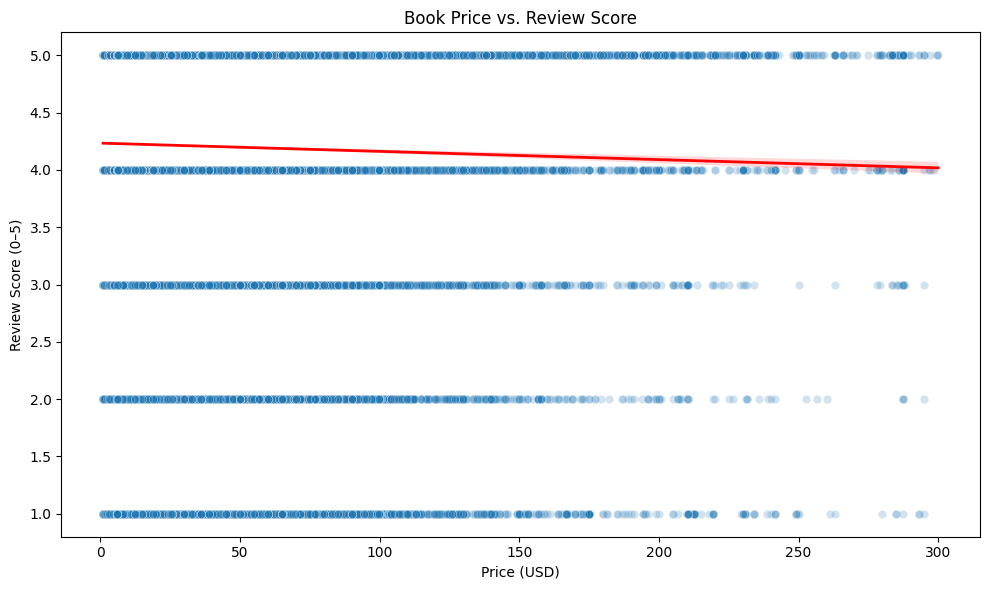

In [ ]:
import seaborn as sns

# Clean and filter price + rating
price_rating_df = merged_df[["Price", "review/score"]].dropna()
price_rating_df = price_rating_df[(price_rating_df["Price"] > 0) & (price_rating_df["Price"] < 300)]

# Correlation
correlation = price_rating_df["Price"].corr(price_rating_df["review/score"])
print(f"Correlation between price and rating: {correlation:.3f}")

# Scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=price_rating_df, x="Price", y="review/score", alpha=0.2)
sns.regplot(data=price_rating_df, x="Price", y="review/score", scatter=False, color="red", line_kws={"linewidth":2})
plt.title("Book Price vs. Review Score")
plt.xlabel("Price (USD)")
plt.ylabel("Review Score (0–5)")
plt.tight_layout()
plt.show()

Almost no correlation between book price and review score

Correlation between price and sentiment polarity: -0.023


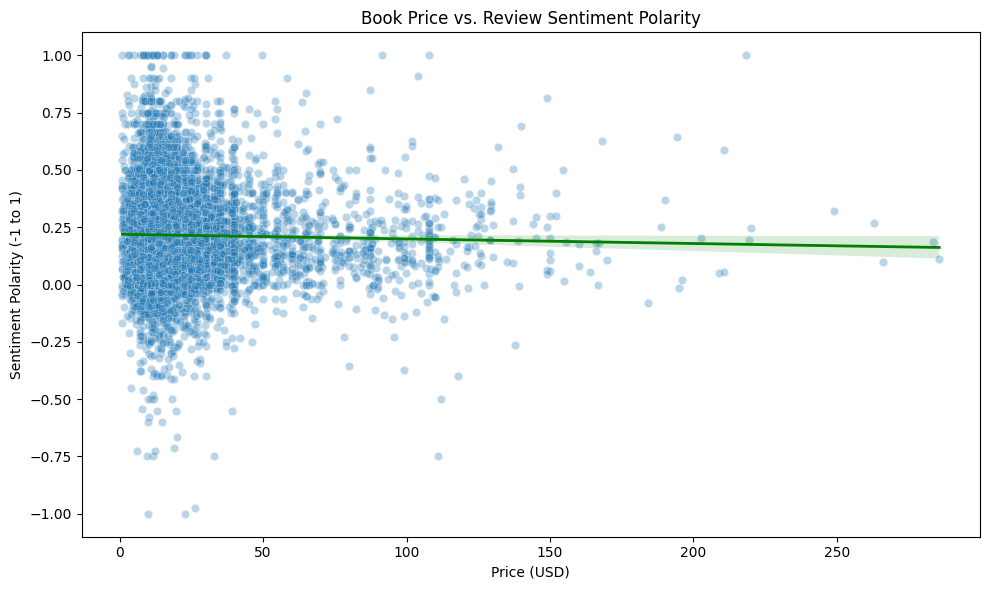

In [ ]:
# Filter and sample review text with price
sample_reviews = merged_df[["Price", "review/text"]].dropna()
sample_reviews = sample_reviews[(sample_reviews["Price"] > 0) & (sample_reviews["Price"] < 300)].sample(n=10000, random_state=42)

# Sentiment polarity calculated using a lexicon within TextBlob
sample_reviews["sentiment"] = sample_reviews["review/text"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Correlation
sentiment_corr = sample_reviews["Price"].corr(sample_reviews["sentiment"])
print(f"Correlation between price and sentiment polarity: {sentiment_corr:.3f}")

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample_reviews, x="Price", y="sentiment", alpha=0.3)
sns.regplot(data=sample_reviews, x="Price", y="sentiment", scatter=False, color="green", line_kws={"linewidth":2})
plt.title("Book Price vs. Review Sentiment Polarity")
plt.xlabel("Price (USD)")
plt.ylabel("Sentiment Polarity (-1 to 1)")
plt.tight_layout()
plt.show()

Almost no correlation between book price and the sentiment of reviews.

Research Question: What are the most common words in 5-star vs. 1-star reviews?

In [ ]:
from collections import Counter
from wordcloud import STOPWORDS
from sklearn.feature_extraction import text
import re

# Filter 1-star and 5-star reviews and sample 10,000 for each
reviews_1star = merged_df[merged_df["review/score"] == 1]["review/text"].dropna().sample(n=10000, random_state=42)
reviews_5star = merged_df[merged_df["review/score"] == 5]["review/text"].dropna().sample(n=10000, random_state=42)

# Define extended stopwords
custom_stopwords = {
    "book", "read", "story", "like", "really", "good", "great", "time",
    "love", "books", "reading", "author", "new", "one", "also",
    "make", "recommend", "life", "people", "think", "way", "years", "work"
}
stopwords = set(STOPWORDS).union(text.ENGLISH_STOP_WORDS).union(custom_stopwords)

# Define cleaning function
def preprocess_text(text_series):
    words = []
    for text in text_series:
        text = str(text).lower()
        text = re.sub(r"[^a-z\s]", "", text)  # remove punctuation/numbers
        tokens = text.split()
        filtered = [word for word in tokens if word not in stopwords and len(word) > 2]
        words.extend(filtered)
    return words

# Preprocess and count words
words_1star = preprocess_text(reviews_1star)
words_5star = preprocess_text(reviews_5star)

freq_1star = Counter(words_1star).most_common(10)
freq_5star = Counter(words_5star).most_common(10)

# Display top words
print("Top 10 words in 1-star reviews:")
print(freq_1star)

print("\nTop 10 words in 5-star reviews:")
print(freq_5star)

Top 10 words in 1-star reviews:
[('dont', 2817), ('characters', 1968), ('know', 1804), ('written', 1611), ('want', 1470), ('say', 1454), ('pages', 1448), ('better', 1396), ('writing', 1340), ('money', 1320)]

Top 10 words in 5-star reviews:
[('novel', 1832), ('world', 1733), ('best', 1675), ('characters', 1648), ('know', 1470), ('written', 1435), ('little', 1264), ('dont', 1162), ('reader', 1049), ('man', 1045)]


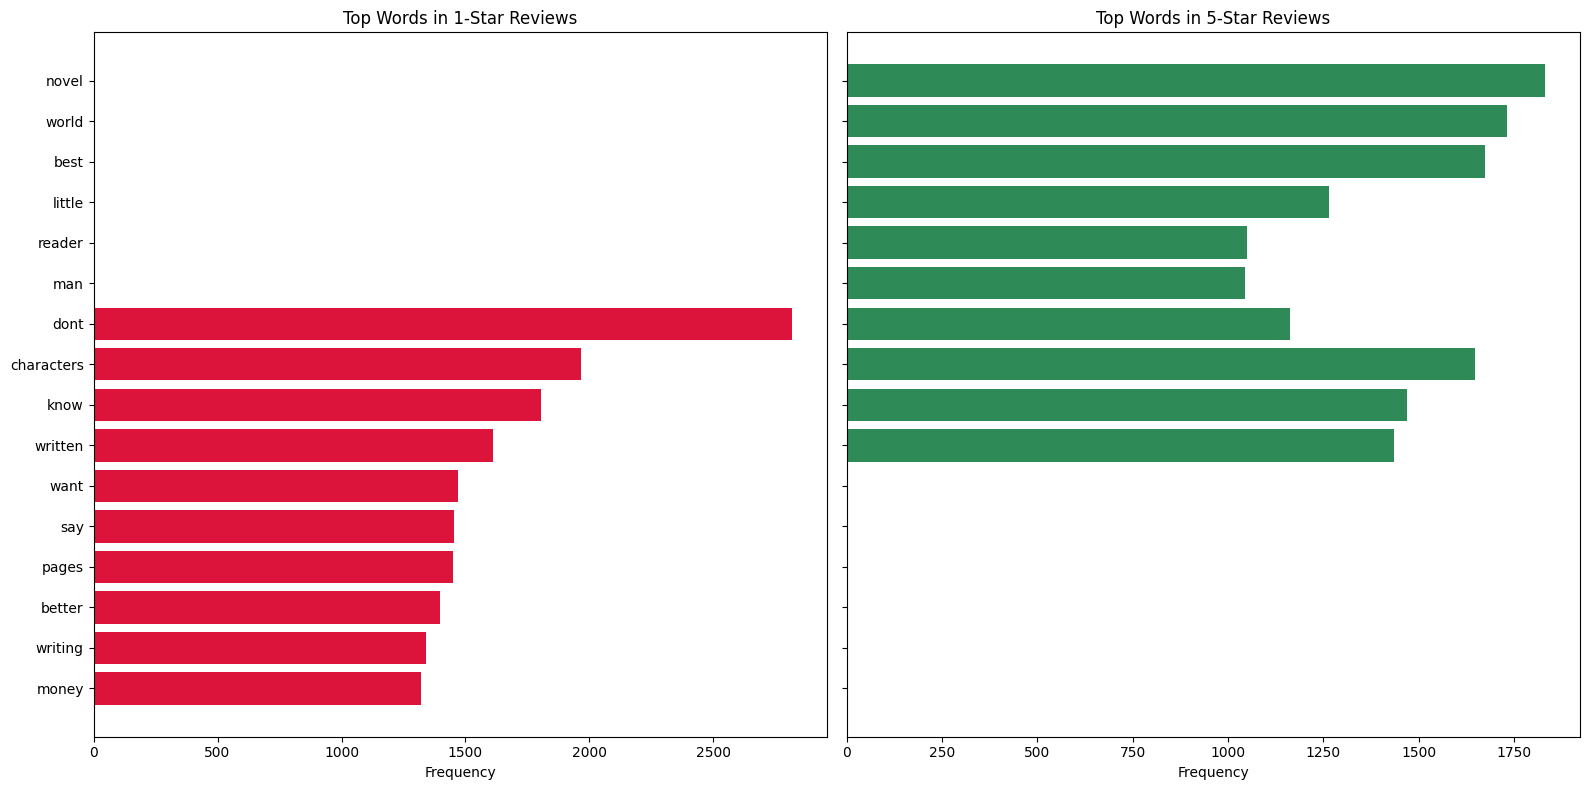

In [ ]:
# Split words and counts
words_1, counts_1 = zip(*freq_1star)
words_5, counts_5 = zip(*freq_5star)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# 1-star plot
axes[0].barh(words_1[::-1], counts_1[::-1], color="crimson")
axes[0].set_title("Top Words in 1-Star Reviews")
axes[0].set_xlabel("Frequency")

# 5-star plot
axes[1].barh(words_5[::-1], counts_5[::-1], color="seagreen")
axes[1].set_title("Top Words in 5-Star Reviews")
axes[1].set_xlabel("Frequency")

plt.tight_layout()
plt.show()

Research Question: How do emotional and subjective words vary by rating?

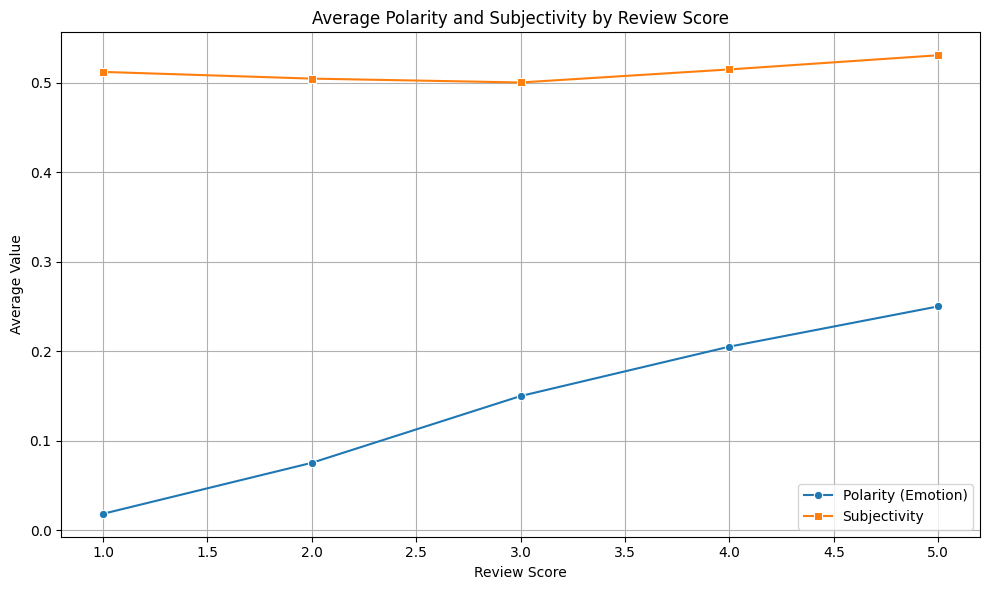

In [ ]:
# Sample 20000 reviews across all scores
sample_reviews = merged_df[["review/score", "review/text"]].dropna().sample(n=20000, random_state=42)

# Compute polarity and subjectivity
def analyze_sentiment(text):
    blob = TextBlob(str(text))
    return pd.Series([blob.sentiment.polarity, blob.sentiment.subjectivity])

sample_reviews[["polarity", "subjectivity"]] = sample_reviews["review/text"].apply(analyze_sentiment)

# Group by score and compute averages
sentiment_by_score = sample_reviews.groupby("review/score")[["polarity", "subjectivity"]].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=sentiment_by_score, x="review/score", y="polarity", marker="o", label="Polarity (Emotion)")
sns.lineplot(data=sentiment_by_score, x="review/score", y="subjectivity", marker="s", label="Subjectivity")
plt.title("Average Polarity and Subjectivity by Review Score")
plt.xlabel("Review Score")
plt.ylabel("Average Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We see that polarity increases as review score increases, which means happier customers write more postive reviews. On the other hand, subjectivity remains constant around 0.5, which means the reviews are moderately subjective.

Topic Modeling: What themes emerge in highly rated vs. poorly rated books?

In [ ]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Ensure NLTK stopwords are downloaded
nltk.download('stopwords')

# Combine NLTK, sklearn, and custom stopwords
nltk_stopwords = set(stopwords.words('english'))
custom_stopwords = {
    "book", "characters", "novel", "thing", "read", "story", "like", "really", "good", "great", "time",
    "love", "books", "reading", "author", "new", "one", "also",
    "make", "recommend", "life", "people", "think", "way", "years", "work", "dont"
}
# Convert the combined set to a list for CountVectorizer
stop_words_list = list(text.ENGLISH_STOP_WORDS.union(nltk_stopwords).union(custom_stopwords))


# Function to clean and tokenize text
# Update clean_text to use the stop_words_list or the frozenset for efficiency
# For cleanup, frozenset is more efficient for 'in' checks
stop_words_set = text.ENGLISH_STOP_WORDS.union(nltk_stopwords).union(custom_stopwords)

def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", str(text).lower())  # lowercase, remove punctuation
    # Use the set for efficient membership testing
    tokens = [word for word in text.split() if word not in stop_words_set and len(word) > 2]
    return " ".join(tokens)

# Function to extract and print LDA topics
def print_topics(model, vectorizer, label, n_top_words=10):
    words = vectorizer.get_feature_names_out()
    print(f"\n🔹 Topics in {label} Reviews:")
    for i, topic in enumerate(model.components_):
        print(f"Topic {i + 1}: " + ", ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Sample and clean reviews by score
review_samples = {}
for score in [1, 3, 5]:
    subset = merged_df[merged_df["review/score"] == score]["review/text"].dropna()
    subset = subset.sample(n=5000, random_state=42)
    review_samples[score] = subset.apply(clean_text)

# LDA Modeling for each score group
for score in [1, 3, 5]:
    reviews = review_samples[score]
    # Pass the list of stop words to CountVectorizer
    vectorizer = CountVectorizer(max_df=0.95, min_df=10, stop_words=stop_words_list)
    dtm = vectorizer.fit_transform(reviews)

    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(dtm)

    label = {1: "1-Star (Negative)", 3: "3-Star (Neutral)", 5: "5-Star (Positive)"}[score]
    print_topics(lda, vectorizer, label)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



🔹 Topics in 1-Star (Negative) Reviews:
Topic 1: know, want, going, didnt, money, series, little, say, written, school
Topic 2: god, world, believe, fact, history, man, say, jesus, christian, bible
Topic 3: version, edition, page, buy, text, amazon, pages, kindle, money, copy
Topic 4: plot, writing, written, boring, character, bad, better, say, didnt, pages
Topic 5: code, information, real, written, use, little, know, lot, examples, used

🔹 Topics in 3-Star (Neutral) Reviews:
Topic 1: man, know, family, old, young, didnt, woman, bad, girl, mother
Topic 2: information, interesting, writing, reader, better, little, looking, chapter, pages, page
Topic 3: plot, series, character, little, end, didnt, interesting, better, stories, thought
Topic 4: world, war, history, man, american, human, god, men, reader, society
Topic 5: use, need, lot, different, know, better, little, want, used, edition

🔹 Topics in 5-Star (Positive) Reviews:
Topic 1: best, series, know, end, character, loved, things, w

Let's make some wordcoulds to visualize the results

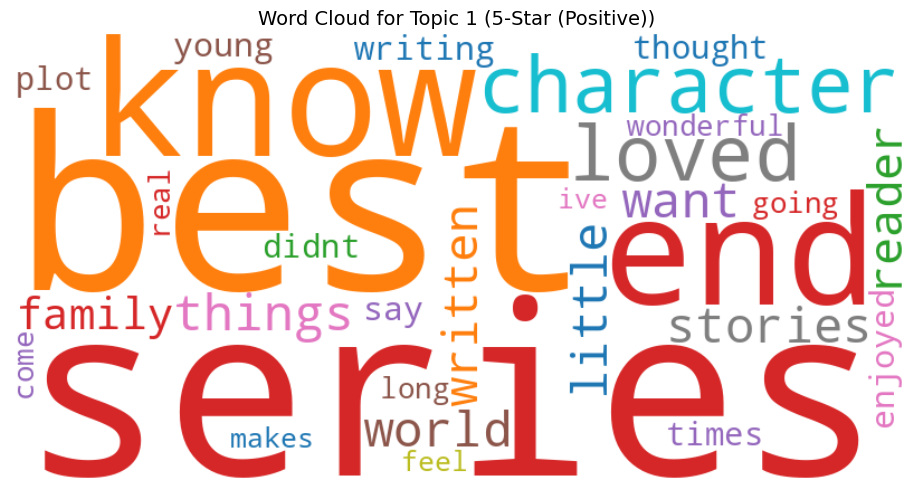

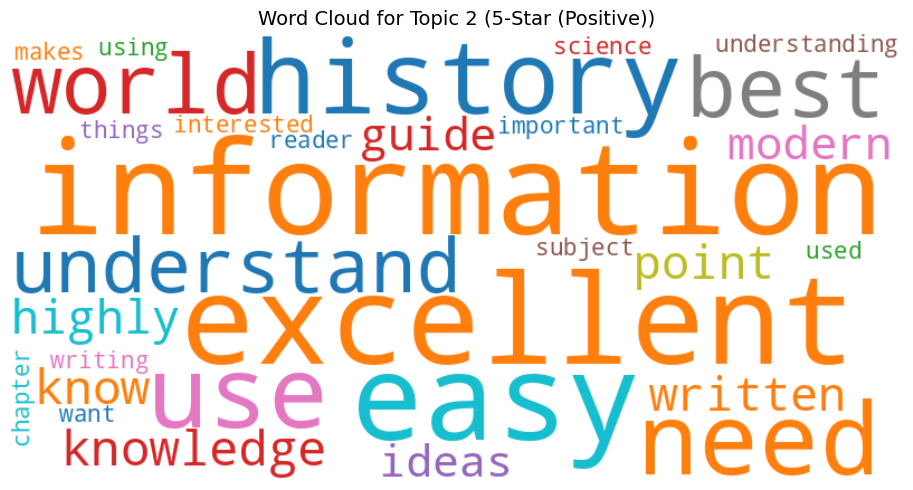

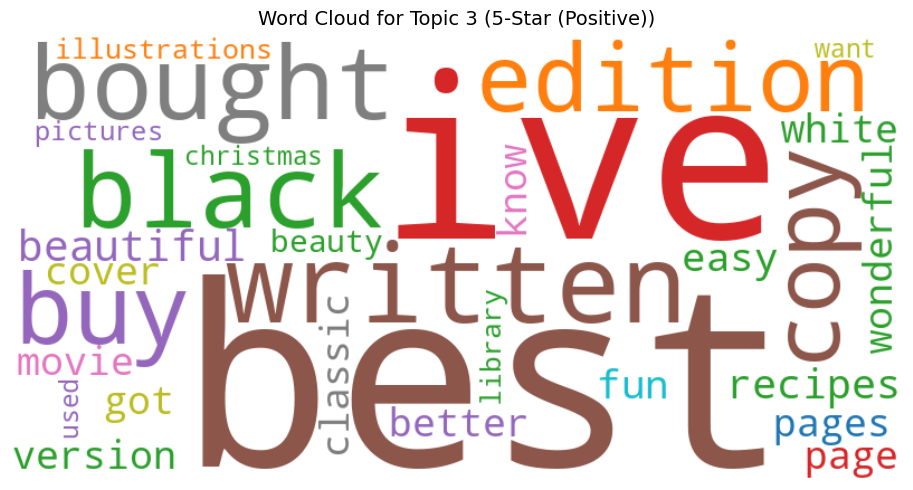

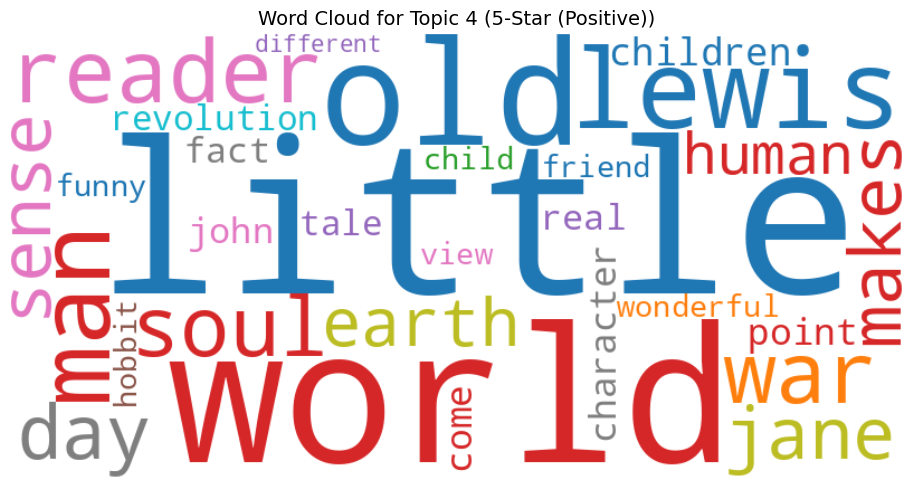

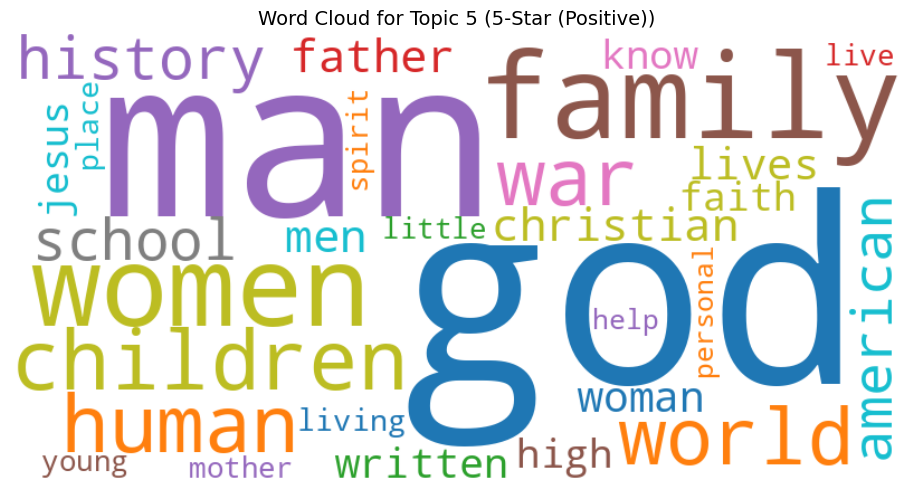

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Number of top words per topic to show
n_top_words = 30

# Get feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Generate and plot word clouds for each topic in the LDA model
for topic_idx, topic in enumerate(lda.components_):
    # Create a dictionary of top words and their weights
    top_words = {feature_names[i]: topic[i] for i in topic.argsort()[:-n_top_words - 1:-1]}

    # Generate the word cloud
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap="tab10"
    ).generate_from_frequencies(top_words)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_idx + 1} ({label})", fontsize=14)
    plt.tight_layout()
    plt.show()

Research Question: Are certain themes, genre dependent?

In [ ]:
import nltk
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Ensure NLTK stopwords are downloaded
nltk.download('stopwords')

# Base and custom stopwords
nltk_stopwords = set(stopwords.words('english'))
custom_stopwords = {
    "book", "characters", "novel", "thing", "read", "story", "like", "really", "good", "great", "time",
    "love", "books", "reading", "author", "new", "one", "also",
    "make", "recommend", "life", "people", "think", "way", "years", "work", "dont"
}
# Convert the combined set to a list for CountVectorizer
stop_words_list = list(text.ENGLISH_STOP_WORDS.union(nltk_stopwords).union(custom_stopwords))

# For cleanup, frozenset is more efficient for 'in' checks
stop_words_set = text.ENGLISH_STOP_WORDS.union(nltk_stopwords).union(custom_stopwords)
# Function to clean text
def clean_text(text):
    # Use the frozenset for efficient lookup during cleaning
    text = re.sub(r"[^a-zA-Z\s]", "", str(text).lower())
    # Corrected 'stop_words' to 'stop_words_set'
    tokens = [word for word in text.split() if word not in stop_words_set and len(word) > 2]
    return " ".join(tokens)

# Function to print LDA topics
def print_topics(model, vectorizer, label, n_top_words=10):
    words = vectorizer.get_feature_names_out()
    print(f"\n📚 Topics for genre: {label}")
    for i, topic in enumerate(model.components_):
        print(f"Topic {i + 1}: " + ", ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Helper to extract first genre if list-like
def extract_primary_genre(cat):
    try:
        return eval(cat)[0] if cat.startswith("[") else cat
    except:
        return None

# Prepare genre column
merged_df["primary_genre"] = merged_df["categories"].dropna().apply(extract_primary_genre)

# Genres to analyze
genres_to_analyze = ["Self-Help", "Poetry", "Cooking", "Juvenile Fiction"]

# Loop through genres
for genre in genres_to_analyze:
    genre_reviews = merged_df[merged_df["primary_genre"] == genre]["review/text"].dropna()

    if len(genre_reviews) < 100:
        print(f"Skipping {genre} (not enough reviews)")
        continue

    genre_reviews = genre_reviews.sample(n=min(3000, len(genre_reviews)), random_state=42)
    genre_reviews_clean = genre_reviews.apply(clean_text)

    # Create DTM with refined stopwords - Use the list version
    vectorizer = CountVectorizer(max_df=0.95, min_df=10, stop_words=stop_words_list)
    dtm = vectorizer.fit_transform(genre_reviews_clean)

    # Fit LDA
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(dtm)

    # Print topics
    print_topics(lda, vectorizer, genre)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



📚 Topics for genre: Self-Help
Topic 1: help, women, anger, men, helpful, understand, personal, positive, depression, difficult
Topic 2: stories, things, know, want, best, ive, need, better, children, helped
Topic 3: writing, world, stories, written, want, reader, page, believe, feel, little
Topic 4: mind, power, spiritual, human, world, body, help, tolle, thoughts, need
Topic 5: person, principles, advice, know, friends, use, business, better, say, best

📚 Topics for genre: Poetry
Topic 1: poetry, poems, poem, words, world, poet, writing, attila, poets, language
Topic 2: edition, whitman, women, grass, leaves, poems, whitmans, version, walt, american
Topic 3: god, gods, gilgamesh, johnson, copy, black, man, history, ancient, omar
Topic 4: poems, poetry, poem, poet, collection, poets, best, world, volume, reader
Topic 5: translation, english, tales, original, canterbury, chaucer, version, middle, modern, tale

📚 Topics for genre: Cooking
Topic 1: recipes, bread, baking, ive, recipe, bo

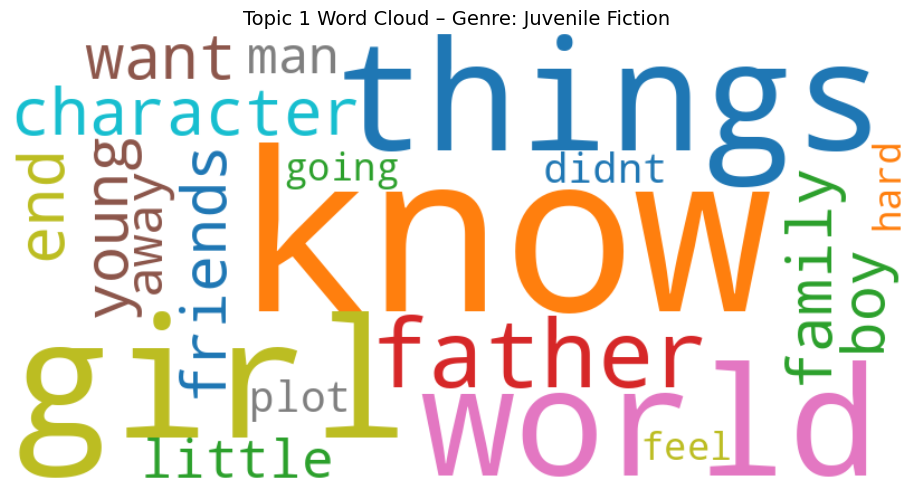

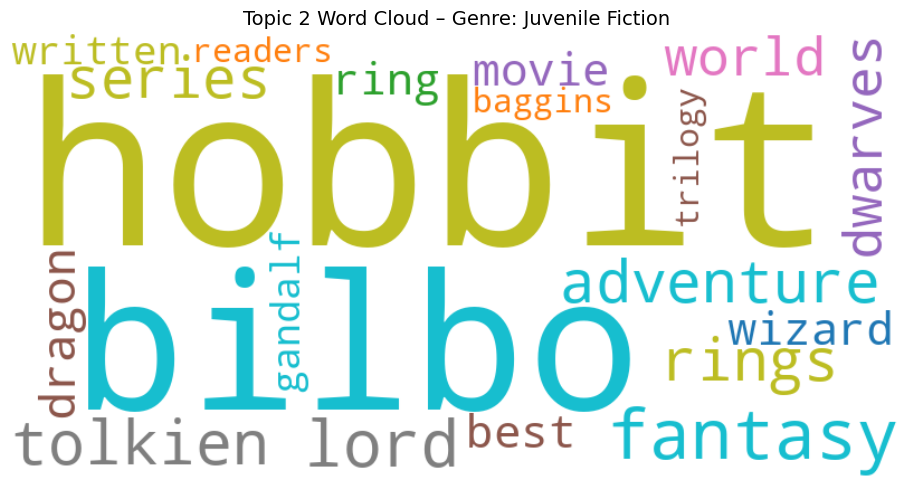

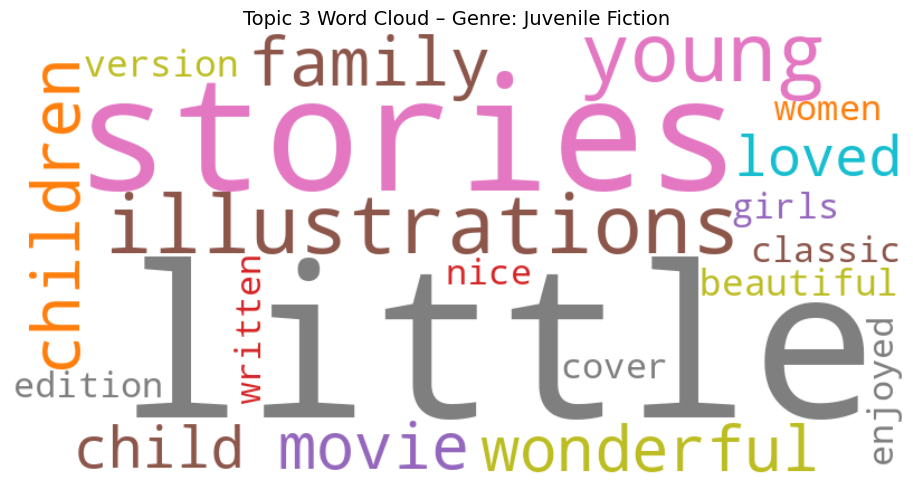

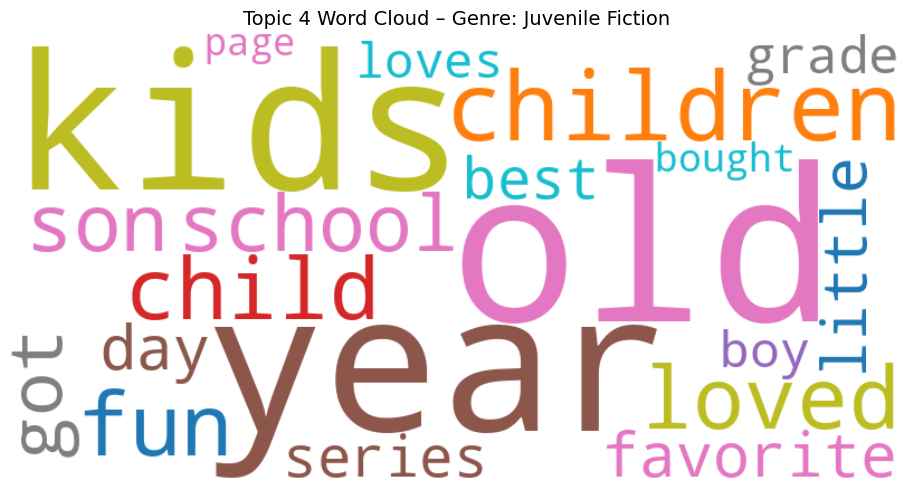

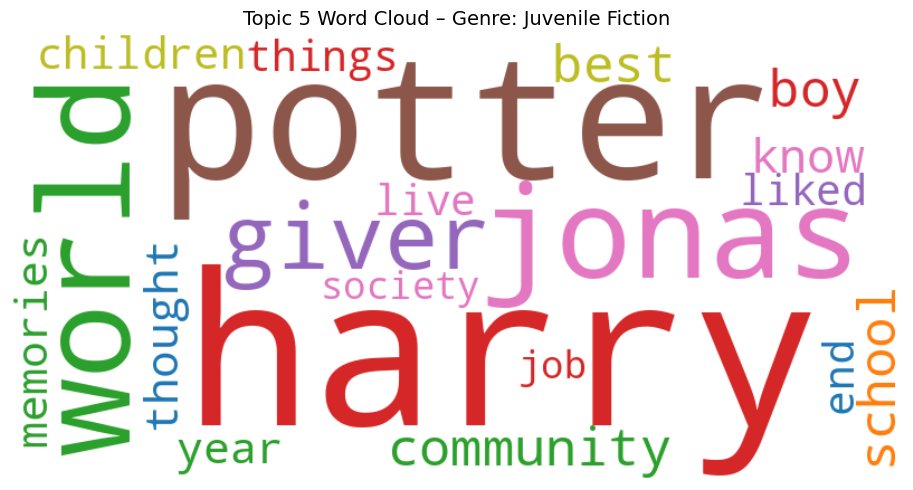

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to plot word cloud for each topic
def plot_topic_wordclouds(lda_model, vectorizer, genre, n_words=20):
    words = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(lda_model.components_):
        topic_words = {words[i]: topic[i] for i in topic.argsort()[:-n_words - 1:-1]}

        wc = WordCloud(
            width=800,
            height=400,
            background_color="white",
            colormap="tab10"
        ).generate_from_frequencies(topic_words)

        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Topic {idx+1} Word Cloud – Genre: {genre}", fontsize=14)
        plt.tight_layout()
        plt.show()
plot_topic_wordclouds(lda, vectorizer, genre)

Randomly Sample 5 % of the dataset to make model training quicker

In [ ]:
ratings_sample = ratings.sample(frac=0.05, random_state=42).reset_index(drop=True)


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
!pip install afinn
from afinn import Afinn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Preprocess
df = ratings_sample.dropna(subset=["User_id", "Id", "review/score", "review/text"])
df = df.rename(columns={"Id": "book_id"})
df["user_id"] = df["User_id"].astype(str)
df["book_id"] = df["book_id"].astype(str)

# Encode categorical variables
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
df["user_index"] = user_encoder.fit_transform(df["user_id"])
df["item_index"] = item_encoder.fit_transform(df["book_id"])

# Compute sentiment score
af = Afinn()
df["sentiment_score"] = df["review/text"].apply(af.score)

df["recommend"] = (df["review/score"] >= 4.0).astype(int)

# Define features and label
X = df[["user_index", "item_index", "sentiment_score"]]
y = df["recommend"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53431 sha256=de34733dee735c86169fd0e018713ec0aacec923687b755a139f82f0d421e155
  Stored in directory: /root/.cache/pip/wheels/ee/d3/a0/f9255ebac29886acb1c28b35b37523f6399677fa06be379f25
Successfully built afinn


<ipython-input-28-4112267303>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="recommend", palette="pastel")


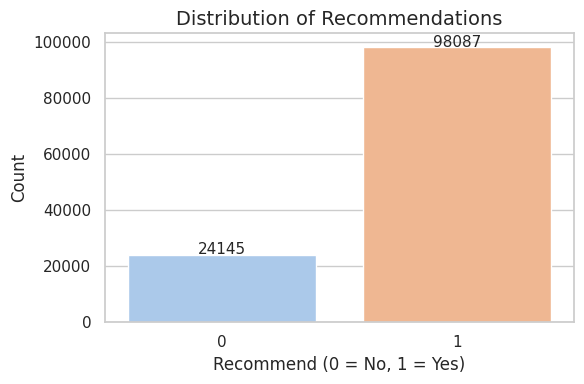

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="recommend", palette="pastel")

plt.title("Distribution of Recommendations", fontsize=14)
plt.xlabel("Recommend (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Count", fontsize=12)

for i, count in enumerate(df["recommend"].value_counts().sort_index()):
    plt.text(i, count + 100, str(count), ha='center', fontsize=11)

plt.tight_layout()
plt.show()

In [ ]:
ratings_sample.shape

#Classification and BPR

<ipython-input-29-3102344596>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_sentiment, x="recommend_label", y="sentiment_score", palette="pastel")


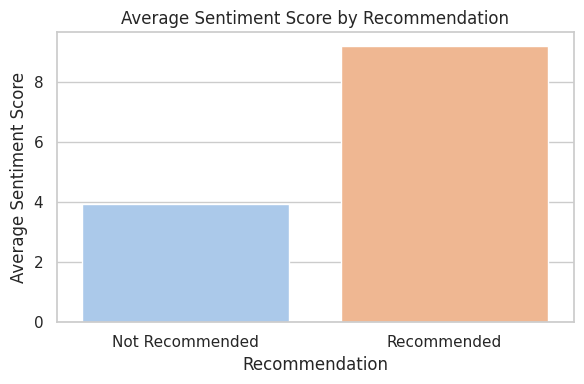

In [ ]:
avg_sentiment = df.groupby("recommend")["sentiment_score"].mean().reset_index()
avg_sentiment["recommend_label"] = avg_sentiment["recommend"].map({0: "Not Recommended", 1: "Recommended"})

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=avg_sentiment, x="recommend_label", y="sentiment_score", palette="pastel")
plt.title("Average Sentiment Score by Recommendation")
plt.xlabel("Recommendation")
plt.ylabel("Average Sentiment Score")
plt.tight_layout()
plt.show()

In [ ]:
df["recommend"] = (df["review/score"] >= 4.0).astype(int)
df.columns

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="recommend", palette="pastel")

plt.title("Distribution of Recommendations", fontsize=14)
plt.xlabel("Recommend (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Count", fontsize=12)

for i, count in enumerate(df["recommend"].value_counts().sort_index()):
    plt.text(i, count + 100, str(count), ha='center', fontsize=11)

plt.tight_layout()
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
#Basic Model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print("Logistic Regression Report:\n", classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


In [ ]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Random Forest Report:\n", classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


In [ ]:
#Gradient Boosting

from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("XGBoost Report:\n", classification_report(y_test, y_pred))


In [ ]:


# Embedding dimensions
num_users = df["user_index"].nunique()
num_items = df["item_index"].nunique()
embedding_dim = 20

user_input = Input(shape=(1,))
item_input = Input(shape=(1,))
sentiment_input = Input(shape=(1,))

user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim)(user_input)
item_embedding = Embedding(input_dim=num_items, output_dim=embedding_dim)(item_input)

user_vec = Flatten()(user_embedding)
item_vec = Flatten()(item_embedding)

concat = Concatenate()([user_vec, item_vec, sentiment_input])

x = Dense(64, activation='relu')(concat)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[user_input, item_input, sentiment_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.fit(
    [X_train["user_index"], X_train["item_index"], X_train["sentiment_score"]],
    y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

y_pred_prob = model.predict([X_test["user_index"], X_test["item_index"], X_test["sentiment_score"]])
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


In [ ]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf', probability=True)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print("SVM Report:\n", classification_report(y_test, y_pred))


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("KNN Report:\n", classification_report(y_test, y_pred))


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from collections import defaultdict

df = ratings_sample.copy()
df = df.dropna(subset=["User_id", "Id", "review/score"])
df = df.rename(columns={"Id": "book_id"})
df["user_id"] = df["User_id"].astype(str)
df["book_id"] = df["book_id"].astype(str)

userIDs = {u: i for i, u in enumerate(df['user_id'].unique())}
itemIDs = {g: i for i, g in enumerate(df['book_id'].unique())}

interactions = [(userIDs[u], itemIDs[g]) for u, g in zip(df['user_id'], df['book_id'])]

itemsPerUser = defaultdict(set)
for u, g in zip(df['user_id'], df['book_id']):
    itemsPerUser[userIDs[u]].add(itemIDs[g])

class BPRbatch(tf.keras.Model):
    def __init__(self, K, lamb):
        super(BPRbatch, self).__init__()
        self.lamb = lamb
        self.betaI = self.add_weight(name="betaI", shape=(len(itemIDs),), initializer="random_normal", trainable=True)
        self.gammaU = self.add_weight(name="gammaU", shape=(len(userIDs), K), initializer="random_normal", trainable=True)
        self.gammaI = self.add_weight(name="gammaI", shape=(len(itemIDs), K), initializer="random_normal", trainable=True)

    def predict(self, u, i):
        return self.betaI[i] + tf.tensordot(self.gammaU[u], self.gammaI[i], 1)

    def reg(self):
        return self.lamb * (tf.nn.l2_loss(self.betaI) +
                            tf.nn.l2_loss(self.gammaU) +
                            tf.nn.l2_loss(self.gammaI))

    def score(self, sampleU, sampleI):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)
        return beta_i + tf.reduce_sum(tf.multiply(gamma_u, gamma_i), axis=1)

    def call(self, sampleU, sampleI, sampleJ):
        x_ui = self.score(sampleU, sampleI)
        x_uj = self.score(sampleU, sampleJ)
        return tf.reduce_mean(tf.nn.softplus(- (x_ui - x_uj)))


# Instantiate model and optimizer
K = 5
lamb = 0.00001
modelBPR = BPRbatch(K, lamb)
optimizer = tf.keras.optimizers.Adam(0.1)

# Training step
def trainingStepBPR(model, interactions):
    Nsamples = 50000
    sampleU, sampleI, sampleJ = [], [], []
    for _ in range(Nsamples):
        u, i = random.choice(interactions)
        j = random.randint(0, len(itemIDs) - 1)
        while j in itemsPerUser[u]:
            j = random.randint(0, len(itemIDs) - 1)
        sampleU.append(u)
        sampleI.append(i)
        sampleJ.append(j)

    sampleU = tf.convert_to_tensor(sampleU, dtype=tf.int32)
    sampleI = tf.convert_to_tensor(sampleI, dtype=tf.int32)
    sampleJ = tf.convert_to_tensor(sampleJ, dtype=tf.int32)

    with tf.GradientTape() as tape:
        loss = model(sampleU=sampleU, sampleI=sampleI, sampleJ=sampleJ)
        reg_loss = model.reg()
        total_loss = loss + reg_loss

    gradients = tape.gradient(total_loss, model.trainable_variables)
    grads_and_vars = [(grad, var) for grad, var in zip(gradients, model.trainable_variables) if grad is not None]

    if grads_and_vars:
        optimizer.apply_gradients(grads_and_vars)

    return total_loss.numpy()



# Training loop
for i in range(1000):
    loss = trainingStepBPR(modelBPR, interactions)


print(f"Iteration {i+1}: Loss = {loss:.4f}")


In [ ]:
def evaluate_hit_rate(model, interactions, itemsPerUser, K=10, num_users_eval=1000):
    hits = 0
    users = list(itemsPerUser.keys())
    sampled_users = random.sample(users, min(num_users_eval, len(users)))

    for u in sampled_users:
        # Positive item (randomly sampled from true interactions)
        pos_item = random.choice(list(itemsPerUser[u]))

        neg_items = set()
        while len(neg_items) < 99:
            j = random.randint(0, len(itemIDs) - 1)
            if j not in itemsPerUser[u]:
                neg_items.add(j)
        item_candidates = list(neg_items) + [pos_item]

        # Score all items for user u
        u_rep = tf.convert_to_tensor([u] * len(item_candidates), dtype=tf.int32)
        i_rep = tf.convert_to_tensor(item_candidates, dtype=tf.int32)
        scores = model.score(u_rep, i_rep).numpy()

        # Rank the items and check if pos_item is in top K
        top_k_items = [item_candidates[i] for i in np.argsort(scores)[-K:]]
        if pos_item in top_k_items:
            hits += 1

    hr = hits / len(sampled_users)
    print(f"Hit Rate @ {K}: {hr:.4f}")
    return hr


In [ ]:
evaluate_hit_rate(modelBPR, interactions, itemsPerUser, K=10)


In [ ]:
def evaluate_auc(model, interactions, itemsPerUser, num_users_eval=1000, num_negatives=50):
    aucs = []
    users = list(itemsPerUser.keys())
    sampled_users = random.sample(users, min(num_users_eval, len(users)))

    for u in sampled_users:
        pos_items = list(itemsPerUser[u])
        if not pos_items:
            continue
        pos_item = random.choice(pos_items)

        # Sample negatives not interacted with
        neg_items = []
        while len(neg_items) < num_negatives:
            j = random.randint(0, len(itemIDs) - 1)
            if j not in itemsPerUser[u]:
                neg_items.append(j)

        # Score positive and negative items
        u_tensor = tf.convert_to_tensor([u] * (1 + num_negatives), dtype=tf.int32)
        i_tensor = tf.convert_to_tensor([pos_item] + neg_items, dtype=tf.int32)
        scores = model.score(u_tensor, i_tensor).numpy()

        pos_score = scores[0]
        neg_scores = scores[1:]

        # Compute AUC: fraction of negatives with score less than pos
        auc = np.mean([1.0 if pos_score > s else 0.0 for s in neg_scores])
        aucs.append(auc)

    overall_auc = np.mean(aucs)
    print(f"AUC: {overall_auc:.4f}")
    return overall_auc


In [ ]:
evaluate_auc(modelBPR, interactions, itemsPerUser)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM (RBF Kernel)": SVC(kernel='rbf'),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "F1 Score": round(f1, 4)
    })

import pandas as pd
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)

results_df

In [ ]:
#LFM